# Imports and data loading

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.spatial.distance import cdist
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
df = pd.read_csv('data_football_ratings.csv')
df.dropna(inplace=True)

# Data cleaning & transformation


In [ ]:
def extract_opponent_and_scores(match_str, team):
    """
    Returns (opp_team, team_score, opp_score).
    - match_str : "France - Romania, 2 - 1"
    - team      : name of the team (e.g., "France" or "Romania")
    """
    pattern = re.compile(r"^([^-]+)\s*-\s*([^,]+),\s*(\d+)\s*-\s*(\d+)$")
    match = pattern.match(match_str)
    if match:
        team1 = match.group(1).strip()
        team2 = match.group(2).strip()
        score1 = int(match.group(3))
        score2 = int(match.group(4))

        if team == team1:
            return (team2, score1, score2)
        elif team == team2:
            return (team1, score2, score1)
        else:
            return (None, None, None)
    else:
        return (None, None, None)

# Create new columns with the extracted infos
df['opp_team'], df['team_score'], df['opp_score'] = zip(*df.apply(
    lambda row: extract_opponent_and_scores(row['match'], row['team']), axis=1
))

df[['match', 'team', 'opp_team', 'team_score', 'opp_score']].head()

,match,team,opp_team,team_score,opp_score
0,"France - Romania, 2 - 1",Romania,France,1,2
1,"France - Romania, 2 - 1",Romania,France,1,2
2,"France - Romania, 2 - 1",Romania,France,1,2
3,"France - Romania, 2 - 1",France,Romania,2,1
4,"France - Romania, 2 - 1",Romania,France,1,2


In [ ]:
def extract_year(date_str):
    """
    Takes as input a string representing a date in the format mm/dd/yyyy.
    Returns the year ('yyyy') or None if nothing is found.
    """
    pattern = re.compile(r"\b(\d{4})\b")
    match = pattern.search(date_str)
    if match:
        return match.group(1)
    else:
        return None

df['year'] = df['date'].apply(extract_year)
df[['date', 'year']].head()

,date,year
0,10/06/2016,2016
1,10/06/2016,2016
2,10/06/2016,2016
3,10/06/2016,2016
4,10/06/2016,2016


# Visualization of Rating Distributions

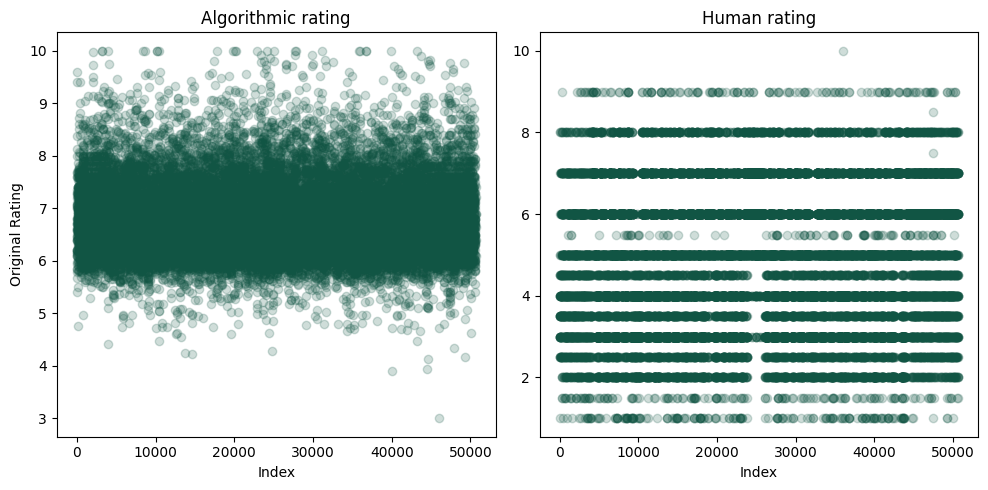

In [ ]:
df.drop(columns=['match', 'date', 'player'], inplace=True)
human_0 = df[df['is_human'] == 0]
human_1 = df[df['is_human'] == 1]

# Scatterplot for ratings distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(human_0.index, human_0['original_rating'], alpha=0.2, color='#115544')
plt.title('Algorithmic rating')
plt.xlabel('Index')
plt.ylabel('Original Rating')

plt.subplot(1, 2, 2)
plt.scatter(human_1.index, human_1['original_rating'], alpha=0.2, color='#115544')
plt.title('Human rating')
plt.xlabel('Index')
plt.tight_layout()
plt.show()

***Ratings distributions differ: algorithmic ratings are continuous and densely packed within a narrower range, while human ratings cluster at discrete intervals.***

# Regression models

## Function definitions

###  Data preparation

In [ ]:
def prep_data(df, test_size=0.2, random_state=42):
    # Définir les caractéristiques catégoriques et numériques
    categorical_features = ['competition', 'team', 'opp_team', 'pos', 'pos_role', 'rater']
    numerical_features = [col for col in df.columns if col not in categorical_features + ['original_rating']]

    # Encodage One-Hot et normalisation
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Séparer les caractéristiques et la variable cible
    target = 'original_rating'
    X = df.drop(columns=[target])
    y = df[target].values

    # Appliquer les transformations
    X = preprocessor.fit_transform(X)
    X = pd.DataFrame(X.toarray(), columns=preprocessor.get_feature_names_out())

    # Séparer en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

### Model Architecture

In [ ]:
def create_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    # Définition du modèle
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.prelu1 = nn.PReLU()
            self.fc2 = nn.Linear(128, 64)
            self.prelu2 = nn.PReLU()
            self.fc3 = nn.Linear(64, 32)
            self.prelu3 = nn.PReLU()
            self.fc4 = nn.Linear(32, 1)

        def forward(self, x):
            x = self.prelu1(self.fc1(x))
            x = self.prelu2(self.fc2(x))
            x = self.prelu3(self.fc3(x))
            return self.fc4(x)

    # Initialisation du modèle
    input_dim = X_train.shape[1]
    model = MLP(input_dim)
    return model

### Model training

In [ ]:
def train_model(model,X_train,
            y_train_tensor,
            X_test_tensor,
            y_test_tensor, num_epochs=500, criterion = nn.L1Loss(), lr=0.001):
    # Définition de la fonction de perte et de l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr)

    # Entraînement
    train_losses, test_losses = [], []
    best_loss = float('inf')
    best_model_state, best_epoch = None, 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Évaluation
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test_tensor)
            test_loss = criterion(test_predictions, y_test_tensor).item()
            test_losses.append(test_loss)

        # Sauvegarde du meilleur modèle
        if test_loss < best_loss - 0.001:
            best_loss = test_loss
            best_epoch = epoch
            best_model_state = model.state_dict()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses, best_model_state, best_epoch

### Evaluation & Visualisation

In [ ]:
def evaluate(train_losses, test_losses, best_model_state, best_epoch, y_test, x_test, criterion=nn.L1Loss(), discrete=False):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
        y_pred = np.clip(y_pred, a_min=1, a_max=10)
        if discrete:
            y_pred = np.round(y_pred*2)/2
        test_loss = criterion(torch.tensor(y_pred), y_test_tensor).item()
        medae = median_absolute_error(y_test, y_pred)
        close1_pred_percentage = np.mean(abs(np.array(y_test) - np.array(y_pred)) <= 1) * 100
        close05_pred_percentage = np.mean(abs(np.array(y_test) - np.array(y_pred)) <= 0.5) * 100
        exact_pred_percentage = np.mean(np.array(y_test) == np.array(y_pred)) * 100

    # First plot: Loss Function
    axes[1].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    axes[1].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', linestyle='--')
    axes[1].axvline(x=best_epoch, color='r', linestyle=':', label='Best Epoch')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("L1 Loss")
    axes[1].set_title("Loss Function Over Training Epochs")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)



    # 2nd plot: Predictions Scatter Plot
    min_value = min(y_test).item()
    axes[0].scatter(y_test, y_pred, alpha=0.5, label="Predictions", color='#99CC99')
    axes[0].plot([min_value, 10], [min_value, 10], 'm--', label="y = x")
    axes[0].set_xlabel("True Rating")
    axes[0].set_ylabel("Predicted Rating")
    axes[0].set_title("Predicted vs. Actual Values")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    print(f"\nTest L1 Loss: {test_loss:.4f}")
    print(f"Test MedAE: {medae:.4f}\n")
    print(f"Prediction within -+1 from actual value: \t{close1_pred_percentage:.2f}%")
    print(f"Prediction within -+.5 from actual value: {close05_pred_percentage:.2f}%\n")
    if discrete:
        print(f"Prediction equal to actual value: {exact_pred_percentage:.2f}%\n")
    pass


## Global Model (both type of ratings)

First we use the entire dataset to train a model that will later serve as a benchmark for evaluating the performance of other models.

In [ ]:
X_train, y_train_tensor, X_test_tensor, y_test_tensor = prep_data(df, test_size=0.2)

model = create_model(X_train, y_train_tensor, X_test_tensor, y_test_tensor)

train_losses, test_losses, best_model_state, best_epoch = train_model(model,
                                                                      X_train, y_train_tensor, X_test_tensor, y_test_tensor,
                                                                      num_epochs=500,
                                                                      criterion=nn.L1Loss(),
                                                                      lr=0.001)


Epoch 50/500, Train Loss: 1.0288, Test Loss: 0.9904
Epoch 100/500, Train Loss: 0.6302, Test Loss: 0.6326
Epoch 150/500, Train Loss: 0.4986, Test Loss: 0.5089
Epoch 200/500, Train Loss: 0.4453, Test Loss: 0.4575
Epoch 250/500, Train Loss: 0.4198, Test Loss: 0.4362
Epoch 300/500, Train Loss: 0.4048, Test Loss: 0.4262
Epoch 350/500, Train Loss: 0.3945, Test Loss: 0.4213
Epoch 400/500, Train Loss: 0.3868, Test Loss: 0.4186
Epoch 450/500, Train Loss: 0.3798, Test Loss: 0.4173
Epoch 500/500, Train Loss: 0.3738, Test Loss: 0.4161


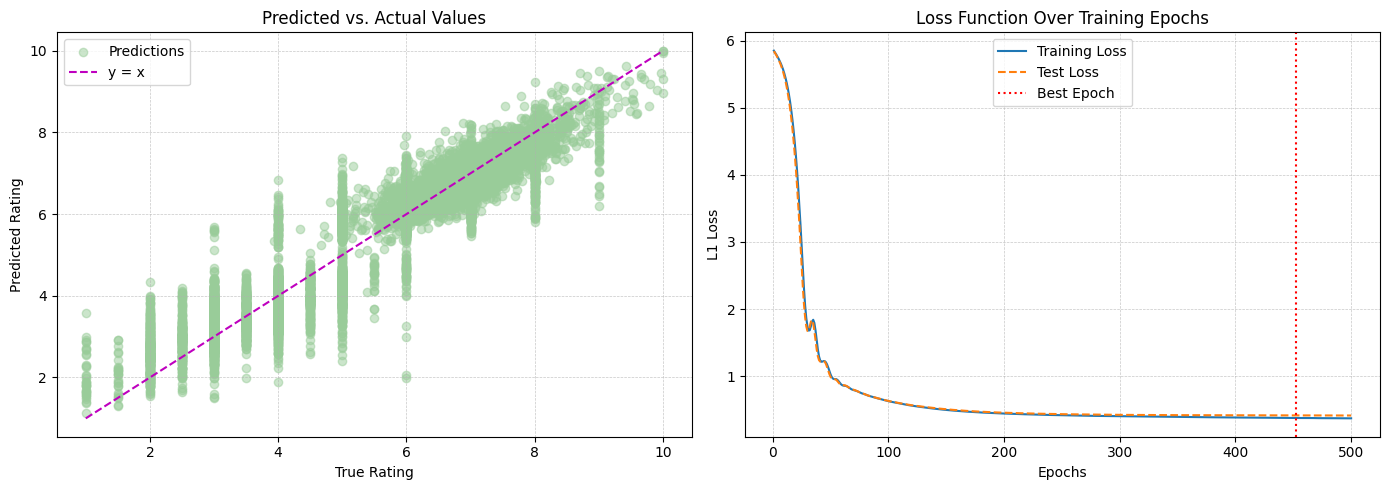


Test L1 Loss: 0.4160
Test MedAE: 0.2961

Prediction within -+1 from actual value: 	91.62%
Prediction within -+.5 from actual value: 68.92%



In [ ]:
evaluate(train_losses, test_losses,
         best_model_state, best_epoch,
         y_test_tensor, X_test_tensor,
         criterion = nn.L1Loss(),
         discrete=False)

## Model for Algorithmic Ratings

In [ ]:
X_train, y_train_tensor, X_test_tensor, y_test_tensor = prep_data(human_0, test_size=0.2)

model = create_model(X_train, y_train_tensor, X_test_tensor, y_test_tensor)

train_losses, test_losses, best_model_state, best_epoch = train_model(model,
                                                                      X_train, y_train_tensor, X_test_tensor, y_test_tensor,
                                                                      num_epochs=500,
                                                                      criterion=nn.L1Loss(),
                                                                      lr=0.001)


Epoch 50/500, Train Loss: 0.6771, Test Loss: 0.6673
Epoch 100/500, Train Loss: 0.3147, Test Loss: 0.3253
Epoch 150/500, Train Loss: 0.2625, Test Loss: 0.2822
Epoch 200/500, Train Loss: 0.2422, Test Loss: 0.2694
Epoch 250/500, Train Loss: 0.2303, Test Loss: 0.2643
Epoch 300/500, Train Loss: 0.2213, Test Loss: 0.2618
Epoch 350/500, Train Loss: 0.2143, Test Loss: 0.2605
Epoch 400/500, Train Loss: 0.2085, Test Loss: 0.2601
Epoch 450/500, Train Loss: 0.2039, Test Loss: 0.2598
Epoch 500/500, Train Loss: 0.1994, Test Loss: 0.2594


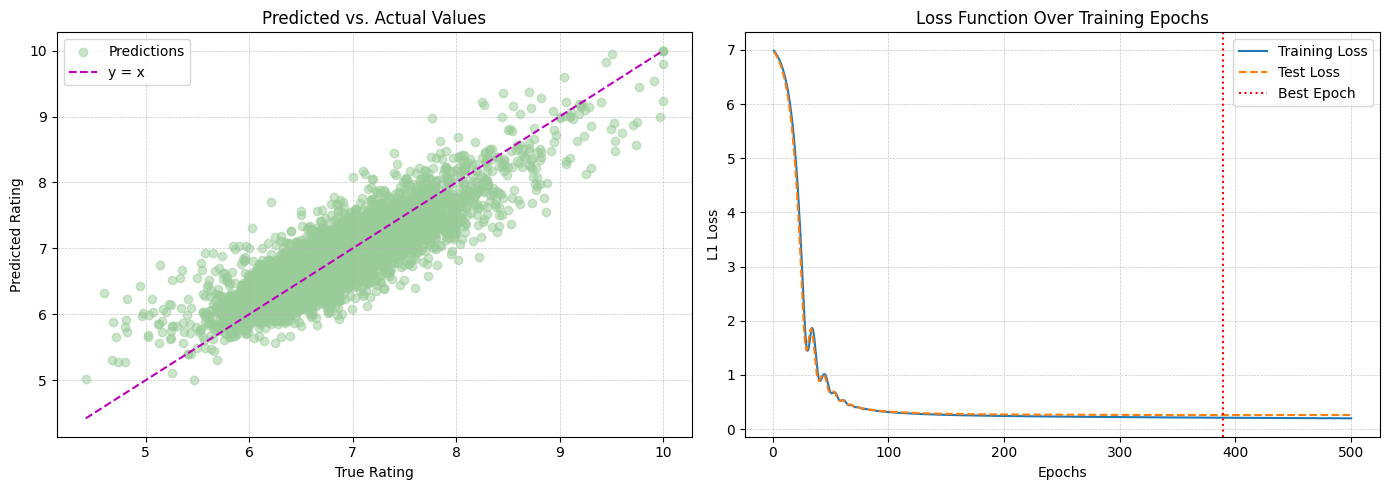


Test L1 Loss: 0.2592
Test MedAE: 0.2044

Prediction within -+1 from actual value: 	98.86%
Prediction within -+.5 from actual value: 87.16%



In [ ]:
evaluate(train_losses, test_losses,
         best_model_state, best_epoch,
         y_test_tensor, X_test_tensor,
         criterion = nn.L1Loss(),
         discrete=False)

## Model for Human Ratings

In [ ]:
X_train, y_train_tensor, X_test_tensor, y_test_tensor = prep_data(human_1, test_size=0.2)

model = create_model(X_train, y_train_tensor, X_test_tensor, y_test_tensor)

train_losses, test_losses, best_model_state, best_epoch = train_model(model,
                                                                      X_train, y_train_tensor, X_test_tensor, y_test_tensor,
                                                                      num_epochs=500,
                                                                      criterion=nn.L1Loss(),
                                                                      lr=0.001)


Epoch 50/500, Train Loss: 1.1256, Test Loss: 1.0830
Epoch 100/500, Train Loss: 0.7479, Test Loss: 0.7639
Epoch 150/500, Train Loss: 0.6052, Test Loss: 0.6206
Epoch 200/500, Train Loss: 0.5400, Test Loss: 0.5742
Epoch 250/500, Train Loss: 0.5080, Test Loss: 0.5634
Epoch 300/500, Train Loss: 0.4846, Test Loss: 0.5592
Epoch 350/500, Train Loss: 0.4655, Test Loss: 0.5581
Epoch 400/500, Train Loss: 0.4487, Test Loss: 0.5579
Epoch 450/500, Train Loss: 0.4325, Test Loss: 0.5594
Epoch 500/500, Train Loss: 0.4178, Test Loss: 0.5620


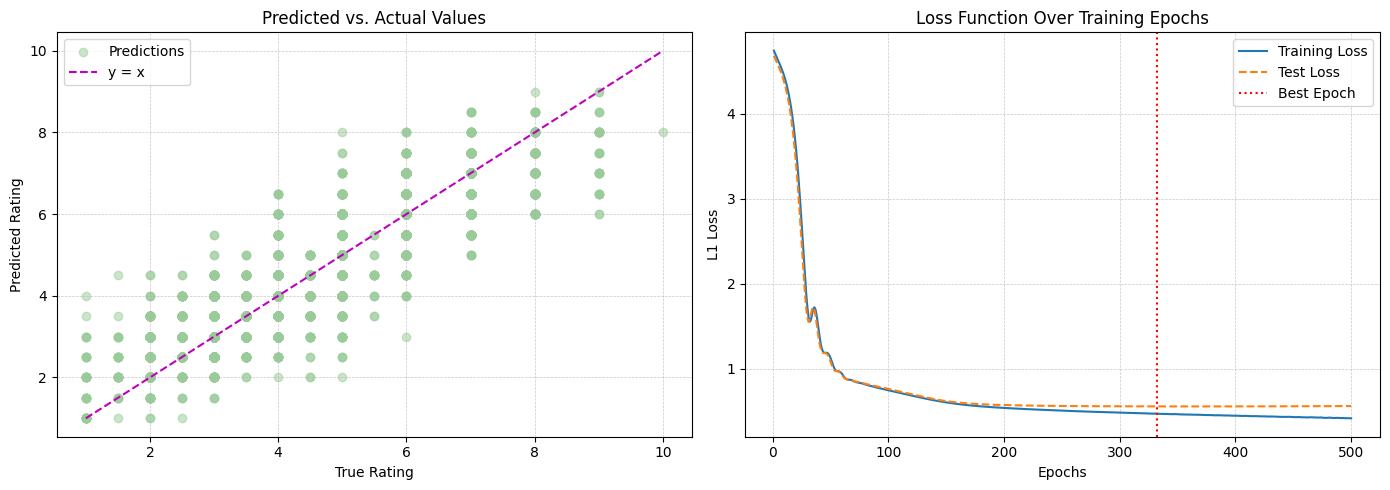


Test L1 Loss: 0.5507
Test MedAE: 0.5000

Prediction within -+1 from actual value: 	91.67%
Prediction within -+.5 from actual value: 71.34%

Prediction equal to actual value: 29.78%



In [ ]:
evaluate(train_losses, test_losses,
         best_model_state, best_epoch,
         y_test_tensor, X_test_tensor,
         criterion = nn.L1Loss(),
         discrete=True)

# Ordinal Classifier for Human Ratings


As human ratings are discrete, we can treat them as classes and use a classifier to predict the exact ratings.

## Data preparation

In [ ]:
df = human_1

unique_vals = np.arange(0, 10.5, 0.5)
rating_to_index = {val: i for i, val in enumerate(unique_vals)}
K = len(unique_vals) # number of class

# Create the categorical for training
df['rating_class'] = df['original_rating'].map(rating_to_index)
df = df.drop(columns=['original_rating'])
print("Mapping des classes:", rating_to_index)

Mapping des classes: {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 4, 2.5: 5, 3.0: 6, 3.5: 7, 4.0: 8, 4.5: 9, 5.0: 10, 5.5: 11, 6.0: 12, 6.5: 13, 7.0: 14, 7.5: 15, 8.0: 16, 8.5: 17, 9.0: 18, 9.5: 19, 10.0: 20}


<ipython-input-16-90dad28e8196>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_class'] = df['original_rating'].map(rating_to_index)


In [ ]:
# Define categorical and numerical features
categorical_features = ['competition', 'team', 'opp_team', 'pos', 'pos_role', 'rater']
numerical_features = [col for col in df.columns if col not in categorical_features + ['rating_class']]

# One-Hot Encoding for categorical variables
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Separate features and target variable
target = 'rating_class'
X = df.drop(columns=[target])
y = df[target].values

# Apply transformations
X = preprocessor.fit_transform(X)  # Keep as sparse matrix initially
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X)
else:
    X = pd.DataFrame(X.toarray(), columns=preprocessor.get_feature_names_out())

# Convert transformed array back to DataFrame with proper column names
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

# Convert transformed array back to DataFrame
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
y_train_tensor = y_train_tensor.squeeze().long()
y_test_tensor  = y_test_tensor.squeeze().long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(y_train_tensor.unique())
print(X_train_tensor.unique())
print(y_test_tensor.unique())
print(X_test_tensor.unique())

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18])
tensor([-6.9328, -6.2405, -6.1911,  ..., 16.9766, 20.6378, 22.0911])
tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 18, 20])
tensor([-6.9328, -4.0529, -4.0008,  ..., 16.9766, 20.6378, 22.0911])


## Model architecture

In [ ]:
class OrdinalNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.05):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer (logits)
        x = self.fc_out(x)

        return x

# Instanciate the model
model = OrdinalNet(
    input_dim=X_train_tensor.shape[1],  # number of features
    hidden_dim=64,
    num_classes=K
)

# Optimiser
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Custom Loss function

Not all misclassifications are equal since the classes (ratings) follow a natural order, meaning the distance between classes is not uniform. To account for this, we will design a loss function where misclassifying a class as a nearby one will be penalized less than misclassifying it as a much more distant class.

In [ ]:
# Matrix of absolute distance (Manhattan)
distance_matrix = cdist(np.arange(K).reshape(-1, 1), np.arange(K).reshape(-1, 1), metric='cityblock')

# Tansformation + Normalisation
distance_matrix = distance_matrix**0.3
distance_matrix = distance_matrix / distance_matrix.max()

distance_df = pd.DataFrame(distance_matrix, index=unique_vals, columns=unique_vals)
print(distance_df.head())

         0.0       0.5       1.0       1.5       2.0       2.5       3.0   \
0.0  0.000000  0.407091  0.501187  0.566014  0.617034  0.659754  0.696845   
0.5  0.407091  0.000000  0.407091  0.501187  0.566014  0.617034  0.659754   
1.0  0.501187  0.407091  0.000000  0.407091  0.501187  0.566014  0.617034   
1.5  0.566014  0.501187  0.407091  0.000000  0.407091  0.501187  0.566014   
2.0  0.617034  0.566014  0.501187  0.407091  0.000000  0.407091  0.501187   

         3.5       4.0       4.5   ...      5.5       6.0       6.5   \
0.0  0.729828  0.759658  0.786980  ...  0.835812  0.857917  0.878768   
0.5  0.696845  0.729828  0.759658  ...  0.812252  0.835812  0.857917   
1.0  0.659754  0.696845  0.729828  ...  0.786980  0.812252  0.835812   
1.5  0.617034  0.659754  0.696845  ...  0.759658  0.786980  0.812252   
2.0  0.566014  0.617034  0.659754  ...  0.729828  0.759658  0.786980   

         7.0       7.5       8.0       8.5       9.0       9.5       10.0  
0.0  0.898523  0.917315  0.9

In [ ]:
def ordinal_distance_loss(logits, targets, distance_matrix):
    """
    Loss computation based on the distance between ordinal classes.

    Arguments:
    - logits: Tensor of shape (batch_size, K), containing unnormalized scores.
    - targets: Tensor of shape (batch_size,), containing integer values representing the target classes [0..K-1].
    - distance_matrix: Tensor of shape (K, K), where D[i, j] represents the distance between classes i and j.

    Returns:
    - loss: Scalar tensor, representing the average loss over the batch.
    """
    # Convert `distance_matrix` to a tensor if it is not already a PyTorch tensor
    if not isinstance(distance_matrix, torch.Tensor):
        distance_matrix = torch.tensor(distance_matrix, dtype=torch.float32, device=logits.device)

    # Validate the targets
    if not (targets.dtype == torch.long and targets.ndim == 1):
        raise ValueError("The `targets` must be a `torch.LongTensor` tensor and have 1 dimension.")

    # Apply softmax to logits to obtain probabilities (batch_size, K)
    probs = F.softmax(logits, dim=1)

    # Validate the values of the targets
    if targets.min() < 0 or targets.max() >= distance_matrix.shape[0]:
        raise ValueError(f"The values of `targets` must be in the range [0, {distance_matrix.shape[0] - 1}].")

    # Index the distance_matrix using targets to obtain the associated distances (batch_size, K)
    dist_for_each_target = distance_matrix[targets]  # Select distances for each target class

    # Compute the loss: weighted sum of distances by the predicted probabilities
    loss = (probs * dist_for_each_target).sum(dim=1).mean()

    return loss

# 5) Function to evaluate the loss on a DataLoader
def evaluate_loss(model, data_loader, distance_matrix):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for Xb, yb in data_loader:
            logits = model(Xb)
            loss = ordinal_distance_loss(logits, yb, distance_matrix)
            batch_size = Xb.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
    return total_loss / total_samples


## Training

In [ ]:

epochs = 300
train_losses = []
test_losses = []

best_model_state = None
best_epoch = 0
best_test_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_loss = 0.0
    nb_train_samples = 0

    for Xb, yb in train_loader:
        logits = model(Xb)
        loss = ordinal_distance_loss(logits, yb, distance_matrix)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = Xb.size(0)
        epoch_train_loss += loss.item() * batch_size
        nb_train_samples += batch_size

    # Average loss over the entire training set
    epoch_train_loss /= nb_train_samples
    train_losses.append(epoch_train_loss)

    # Evaluation on the test set
    epoch_test_loss = evaluate_loss(model, test_loader, distance_matrix)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_epoch = epoch
        best_model_state = model.state_dict().copy()  # Copy the model state

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} "
              f"- Train Loss: {epoch_train_loss:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}")

# Reload the best model after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"The best model during training was found at epoch {best_epoch} "
          f"with a test loss of {best_test_loss:.4f}.")

Epoch 20/300 - Train Loss: 0.2653, Test Loss: 0.2855
Epoch 40/300 - Train Loss: 0.2573, Test Loss: 0.2817
Epoch 60/300 - Train Loss: 0.2505, Test Loss: 0.2846
Epoch 80/300 - Train Loss: 0.2466, Test Loss: 0.2809
Epoch 100/300 - Train Loss: 0.2359, Test Loss: 0.2756
Epoch 120/300 - Train Loss: 0.2292, Test Loss: 0.2755
Epoch 140/300 - Train Loss: 0.2237, Test Loss: 0.2735
Epoch 160/300 - Train Loss: 0.2197, Test Loss: 0.2756
Epoch 180/300 - Train Loss: 0.2162, Test Loss: 0.2755
Epoch 200/300 - Train Loss: 0.2145, Test Loss: 0.2748
Epoch 220/300 - Train Loss: 0.2103, Test Loss: 0.2780
Epoch 240/300 - Train Loss: 0.2082, Test Loss: 0.2760
Epoch 260/300 - Train Loss: 0.2075, Test Loss: 0.2754
Epoch 280/300 - Train Loss: 0.2062, Test Loss: 0.2759
Epoch 300/300 - Train Loss: 0.2064, Test Loss: 0.2742
The best model during training was found at epoch 175 with a test loss of 0.2718.


## Results

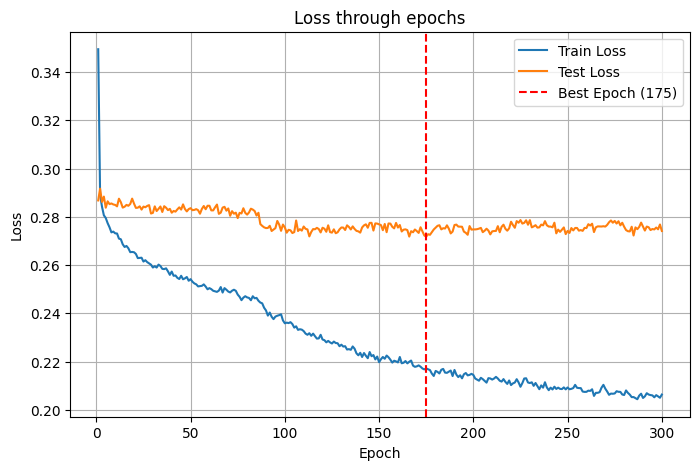

In [ ]:
# Test vs Train Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss through epochs')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE)  : 0.5581

Prediction within ±1 from actual value:	 92.81%
Prediction within ±.5 from actual value: 56.56%
Prediction equal to actual value: 	 44.44%



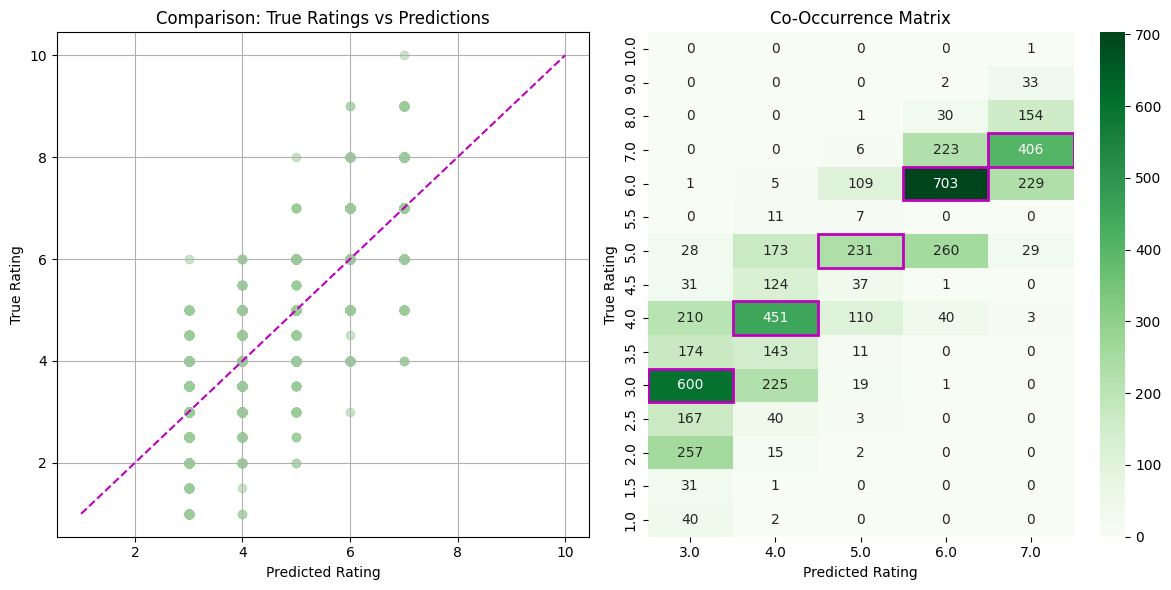

In [ ]:

# Evaluate the model
model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor)
    probs_test  = F.softmax(logits_test, dim=1)
    pred_classes = probs_test.argmax(dim=1)  # indices [0..K-1]

# Reconstruct the actual ratings from the classes
pred_ratings = [unique_vals[int(c)] for c in pred_classes]
true_ratings = [unique_vals[int(t)] for t in y_test_tensor]


# Visualise results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: scatter plot
ax1 = axes[0]
ax1.scatter(pred_ratings, true_ratings, alpha=0.5, color='#99CC99')
ax1.plot([np.min(true_ratings), np.max(true_ratings)],
         [np.min(true_ratings), np.max(true_ratings)], 'm--', label="y = x")
ax1.set_ylabel("True Rating")
ax1.set_xlabel("Predicted Rating")
ax1.set_title("Comparison: True Ratings vs Predictions")
ax1.grid(True)

# Second plot: co-occurrence matrix
occurrence_matrix = pd.crosstab(pd.Series(true_ratings, name="True Rating"),
                                pd.Series(pred_ratings, name="Predicted Rating"))

ax2 = axes[1]
sns.heatmap(occurrence_matrix, annot=True, fmt="d", cmap="Greens", cbar=True, ax=ax2)
ax2.invert_yaxis()


# Highlight the diagonal (if applicable)
true_values = occurrence_matrix.index.tolist()
pred_values = occurrence_matrix.columns.tolist()
for val in true_values:
    if val in pred_values:  # Check if the value exists in both axes
        x = pred_values.index(val)
        y = true_values.index(val)
        ax2.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='m', lw=2))

ax2.set_xlabel("Predicted Rating")
ax2.set_ylabel("True Rating")
ax2.set_title("Co-Occurrence Matrix")

# Compute evaluation metrics
mae = mean_absolute_error(true_ratings, pred_ratings)
ok_range_percentage = np.mean(abs(np.array(true_ratings) - np.array(pred_ratings))<=1) * 100
good_range_percentage = np.mean(abs(np.array(true_ratings) - np.array(pred_ratings))<=.5) * 100
exact_match_percentage = np.mean(np.array(true_ratings) == np.array(pred_ratings)) * 100

# Print evaluation metrics
print(f"Mean Absolute Error (MAE)  : {mae:.4f}\n")
print(f"Prediction within ±1 from actual value:\t {ok_range_percentage:.2f}%")
print(f"Prediction within ±.5 from actual value: {good_range_percentage:.2f}%")
print(f"Prediction equal to actual value: \t {exact_match_percentage:.2f}%\n")

# Print plots
plt.tight_layout()
plt.show()